In [1]:
from hana_ml import dataframe
from data_load_utils import DataSets, Settings

In [2]:
url, port, user, pwd = Settings.load_config("../../config/e2edata.ini")
connection_context = dataframe.ConnectionContext(url, port, user, pwd)

In [3]:
import pandas as pd
import numpy as np
def geometric_brownian_motion(T = 1, N = 2, mu = -0.01, sigma = 0.001, S0 = 2):        
    dt = float(T)/N
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size = N) 
    W = np.cumsum(W)*np.sqrt(dt) ### standard brownian motion ###
    X = (mu-0.5*sigma**2)*t + sigma*W 
    S = S0*np.exp(X) ### geometric brownian motion ###
    return S

dates = pd.date_range('2018-03-01', '2018-03-10',freq='H')
T = (dates.max()-dates.min()).days / 365
N = dates.size
start_price = 1000
y = pd.DataFrame()
y['INDEX'] = dates
y['Y'] = geometric_brownian_motion(T, N, sigma=0.1, S0=start_price)

In [4]:
df = dataframe.create_dataframe_from_pandas(connection_context, y, '#AMF_TEST', force=True).sort("INDEX")

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


In [5]:
df.shape[0]

217

In [6]:
train_df = df.filter("DAYS_BETWEEN(INDEX, '2018-03-06') > 0")
test_df = df.filter("DAYS_BETWEEN(INDEX, '2018-03-06') <= 0")

In [7]:
from hana_ml.algorithms.pal.tsa.additive_model_forecast import AdditiveModelForecast

amf = AdditiveModelForecast(growth='linear')
amf.fit(data=train_df)
pred_data = amf.predict(data=test_df)

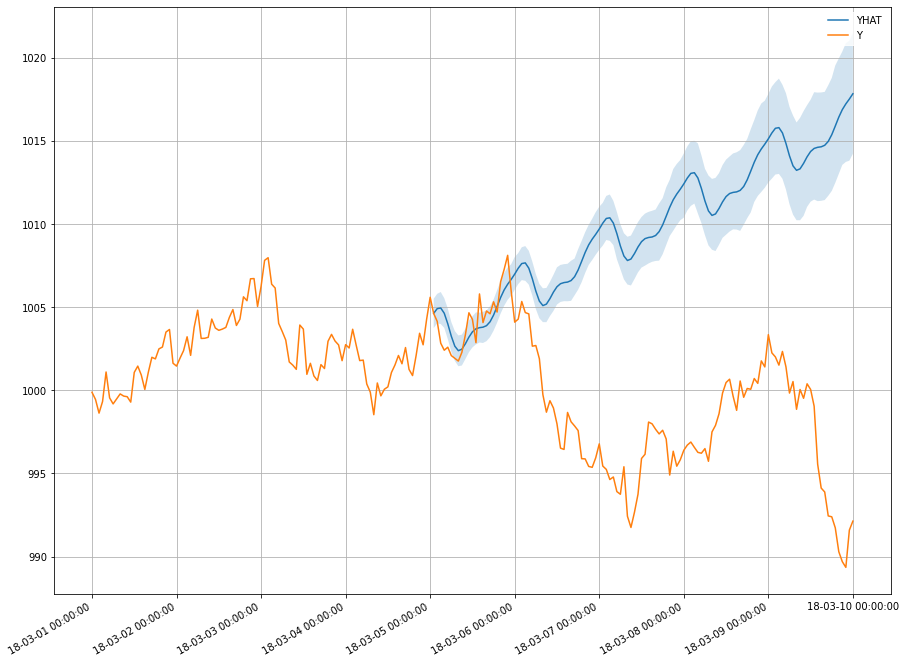

In [8]:
%matplotlib inline

from hana_ml.visualizers.visualizer_base import forecast_line_plot

ax = forecast_line_plot(pred_data=pred_data.set_index("INDEX"),
                        actual_data=df.set_index("INDEX"),
                        confidence=("YHAT_LOWER", "YHAT_UPPER"),
                        max_xticklabels=10, )
